In [7]:
import os

!pip install wget
if not os.path.exists('thinkdsp.py'):
    !python -m wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from thinkdsp import Wave
from thinkdsp import decorate
import scipy.signal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Упражнение 8.1

Блокнот для этой главы — chap08.ipynb. Прочитайте его и запустите код.

В нем есть интерактивный виджет, где можно экспериментировать с параметрами гауссова окна и изучить их влияние на частоту среза.

Что случится, если при увеличении ширины гауссова окна std не увеличивать число элементов в окне M?

In [8]:
from thinkdsp import SquareSignal

def zero_pad(array, n):
    """Extends an array with zeros.

    array: NumPy array
    n: length of result

    returns: new NumPy array
    """
    res = np.zeros(n)
    res[:len(array)] = array
    return res


def plot_filter(M=11, std=2):
    signal = SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth =  Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded =  zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    plt.plot(np.abs(dft_gaussian), color='gray', label='Gaussian filter')
    plt.plot(ratio, label='amplitude ratio')

    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')
    plt.show()

In [9]:
slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=11, description='M', min=2), FloatSlider(value=2.0, description='std', m…

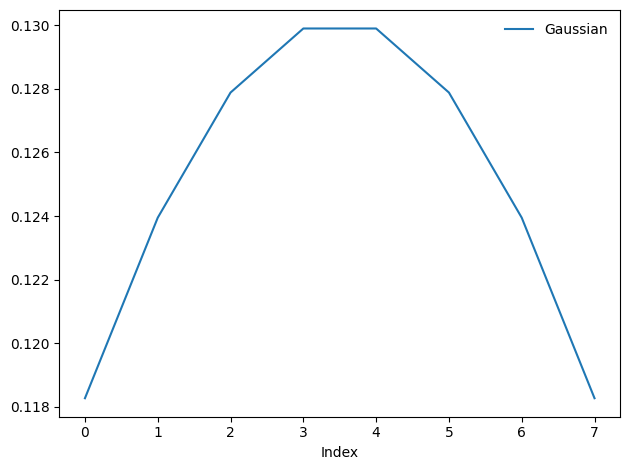

In [10]:
gaussian = scipy.signal.gaussian(M=8, std=8)
gaussian /= sum(gaussian)

plt.plot(gaussian, label='Gaussian')
decorate(xlabel='Index')

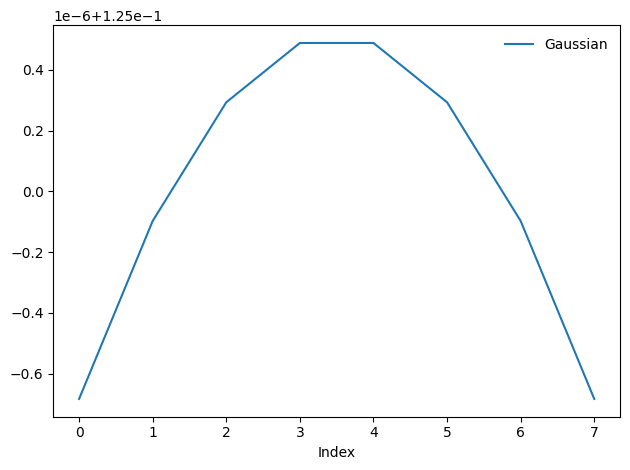

In [11]:
gaussian = scipy.signal.gaussian(M=8, std=800)
gaussian /= sum(gaussian)

plt.plot(gaussian, label='Gaussian')
decorate(xlabel='Index')

При увеличении std, кривая становится шире, а сам БПФ меньше.

# Упражнение 8.2

В этой главе утверждается, что преобразование Фурье гауссовой кривой — также гауссова кривая. Для дискретного преобразования Фурье это сотношение приблизительно верно.

Попробуйте его на нескольких примерах. Что происходит с преобразованием Фурье, если меняется std?

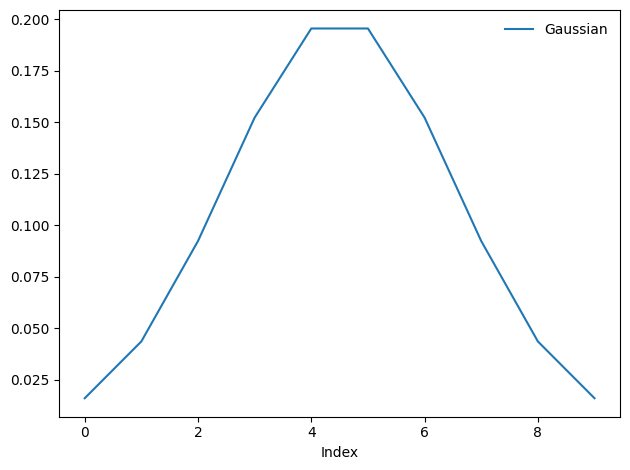

In [12]:
gaussian = scipy.signal.gaussian(M=10, std=2)
gaussian /= sum(gaussian)

plt.plot(gaussian, label='Gaussian')
decorate(xlabel='Index')

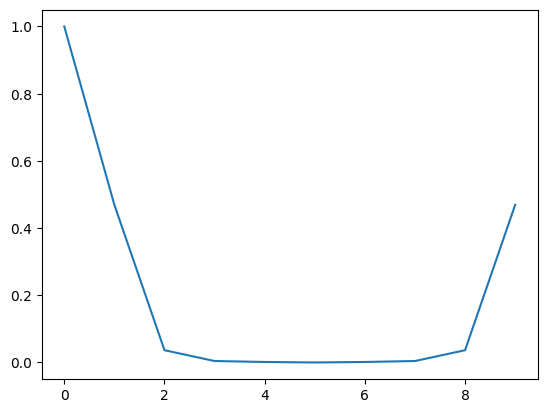

In [13]:
gaussian_fft = np.fft.fft(gaussian)
plt.plot(abs(gaussian_fft), label='Gaussian')

Осуществим свёртку:

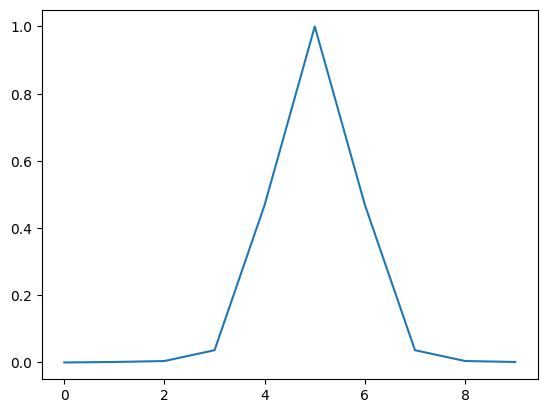

In [14]:
gaussian_fft_rolled = np.roll(gaussian_fft, len(gaussian) // 2)
plt.plot(abs(gaussian_fft_rolled), label='Gaussian')

Если std гауссовой кривой увеличивается, то преобразование Фурье становится уже.

# Упражнение 8.3

В упражнениях к главе 3 изучалось влияние на утечки спектра окна Хэмминга и некоторых других, предоставляемых NumPy. Глубже понять эти окна можно, изучив их ДПФ.

В дополнение к Гауссову окну, использованному в этой главе, создайте окно Хемминга тех же размеров. Дополните окно нулями и напечатайте его ДПФ. Какое окно больше подходит для фильтра НЧ? Полезно напечатать ДПФ с логарифмическим масштабом по y.

Поэкспериментируйте с разными окнами и разными размерами этих окон.

С подобной задачей мы уже работали в лабораторной работе № 3. Вспомним:

In [28]:
from thinkdsp import Signal
from math import pi
from thinkdsp import unbias,normalize
import numpy as np


class SawtoothSignal(Signal):

    def __init__(self, freq=440, amp=1.0, offset = 0):
        self.freq = freq
        self.amp = amp
        self.offset = offset

    @property
    def period(self): return 1.0 / self.freq

    def evaluate(self,ts):
        cycles = self.freq * ts + self.offset / np.pi / 2
        frac, _ = np.modf(cycles)
        ys = normalize(unbias(frac), self.amp)
        return ys

In [29]:
from thinkdsp import SquareSignal

signal = SquareSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)

In [30]:
wave.make_audio()

In [31]:
M = 15
std = 2.5

blackman = np.blackman(M)
gauss = scipy.signal.gaussian(M,std)
hamming = np.hamming(M)
hanning = np.hanning(M)

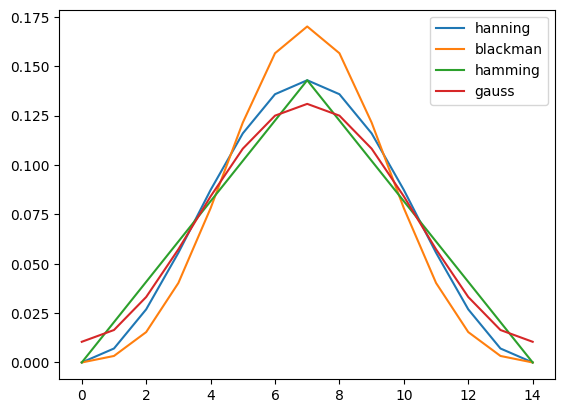

In [32]:
array  = [hanning,blackman,barlett,hamming,gauss]
labels = ['hanning','blackman','hamming','gauss']

for elem, label in zip(array,labels):
    elem /= sum(elem)
    plt.plot(elem,label=label)
plt.legend()

Дполним окно нулями и выведем ДПФ:

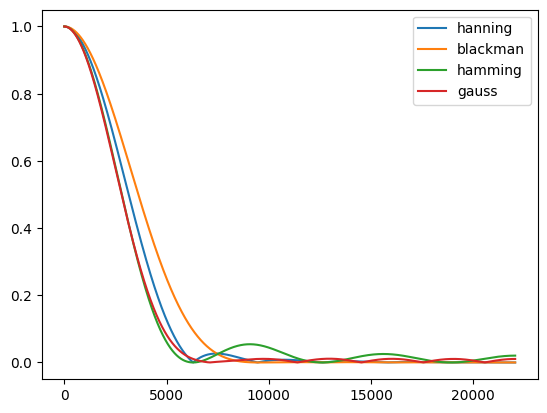

In [33]:
for elem, label in zip(array, labels):
    padded =  zero_pad(elem, len(wave))
    dft_window = np.fft.rfft(padded)
    plt.plot(abs(dft_window), label=label)
plt.legend()

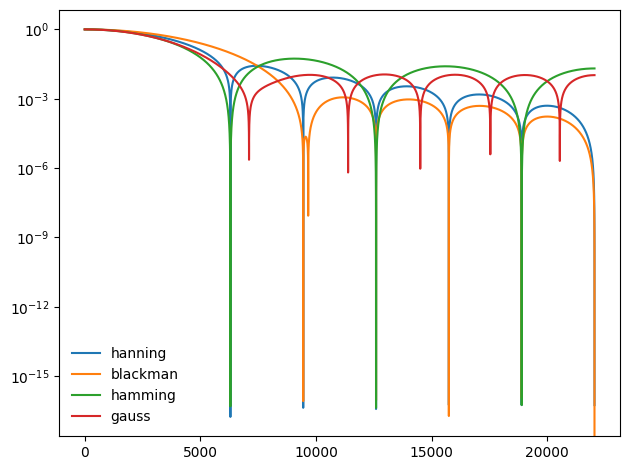

In [34]:
for elem, label in zip(array, labels):
    padded =  zero_pad(elem, len(wave))
    dft_window = np.fft.rfft(padded)
    plt.plot(abs(dft_window), label=label)
plt.legend()
decorate(yscale='log')

Мы можем видеть, что окна Хэмминга и Ханнинга поначалу спадают быстрее, чем два других окна. А окна Хэмминга и Гаусса имеют самые стойкие боковые лепестки.

Окно Ханнинга имеет наилучшее сочетание быстрого снижения и минимальных боковых лепестков.